In [1]:
!pip install git+https://github.com/IBM/tsfm.git
!pip install transformers pandas scikit-learn matplotlib
!pip install transformers
!pip install transformers[torch]
!pip install torch

  Cloning https://github.com/IBM/tsfm.git to /tmp/pip-req-build-ui9h8pyy
  Running command git clone --filter=blob:none --quiet https://github.com/IBM/tsfm.git /tmp/pip-req-build-ui9h8pyy
  Resolved https://github.com/IBM/tsfm.git to commit a730b5d4c511b2fc24a9ac7e5841e1dc3077e893
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 37.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 42.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 40.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 27.0 MB/s eta 0:00:00
     ━━━━

GOLD PRICE

In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from transformers import PatchTSTConfig, PatchTSTForPrediction, Trainer, TrainingArguments, EarlyStoppingCallback, DefaultDataCollator
from tsfm_public.toolkit.dataset import ForecastDFDataset
from tsfm_public.toolkit.time_series_preprocessor import TimeSeriesPreprocessor
from tsfm_public.toolkit.util import select_by_index
import torch

# Đọc dữ liệu từ file CSV
data = pd.read_csv('/content/gold_price_2018_2024.csv')

# Chuyển đổi cột Date thành định dạng datetime
data['Date'] = pd.to_datetime(data['Date'])
timestamp_column = 'Date'
forecast_columns = ['Value (USD per troy ounce)']

def train_and_evaluate_gold(train_ratio):
    # Chia dữ liệu thành tập huấn luyện và kiểm tra theo tỷ lệ train_ratio
    train_size = int(len(data) * train_ratio)
    test_size = len(data) - train_size
    train, test = train_test_split(data, test_size=test_size, shuffle=False)

    # Chuẩn bị scaler riêng để sử dụng
    scaler = StandardScaler()

    # Fit scaler trên dữ liệu huấn luyện
    train_scaled = scaler.fit_transform(train[forecast_columns])
    test_scaled = scaler.transform(test[forecast_columns])

    # Tạo DataFrame mới với dữ liệu đã chuẩn hóa và giữ lại cột 'Date'
    train_scaled_df = pd.DataFrame(train_scaled, columns=forecast_columns, index=train.index)
    test_scaled_df = pd.DataFrame(test_scaled, columns=forecast_columns, index=test.index)
    train_scaled_df['Date'] = train['Date']
    test_scaled_df['Date'] = test['Date']

    # Đảm bảo context_length không vượt quá độ dài chuỗi đầu vào và tối thiểu là 128
    min_context_length = 128  # Thiết lập context_length tối thiểu
    max_context_length = min(512, len(train_scaled_df), len(test_scaled_df))
    context_length = max(max_context_length, min_context_length)  # Đảm bảo context_length không nhỏ hơn min_context_length

    # Chuyển đổi dữ liệu thành định dạng thích hợp cho mô hình PatchTST
    forecast_horizon = 96
    patch_length = 16
    num_workers = 0  # Đặt số lượng luồng xử lý thành 0 để tránh multiprocessing
    batch_size = 64

    # Chuẩn bị dữ liệu sử dụng scaler đã chuẩn hóa
    time_series_preprocessor = TimeSeriesPreprocessor(
        timestamp_column=timestamp_column,
        id_columns=[],
        input_columns=forecast_columns,
        output_columns=forecast_columns,
        scaling=False,  # Đã chuẩn hóa bên ngoài
    )

    train_data = select_by_index(train_scaled_df, start_index=0, end_index=len(train_scaled_df))
    test_data = select_by_index(test_scaled_df, start_index=0, end_index=len(test_scaled_df))

    time_series_preprocessor = time_series_preprocessor.train(train_data)

    train_dataset = ForecastDFDataset(
        time_series_preprocessor.preprocess(train_data),
        id_columns=[],
        timestamp_column=timestamp_column,
        target_columns=forecast_columns,
        context_length=context_length,
        prediction_length=forecast_horizon,
    )

    test_dataset = ForecastDFDataset(
        time_series_preprocessor.preprocess(test_data),
        id_columns=[],
        timestamp_column=timestamp_column,
        target_columns=forecast_columns,
        context_length=context_length,
        prediction_length=forecast_horizon,
    )

    # Cấu hình mô hình PatchTST
    config = PatchTSTConfig(
        num_input_channels=len(forecast_columns),
        context_length=context_length,
        patch_length=patch_length,
        patch_stride=patch_length,
        prediction_length=forecast_horizon,
        random_mask_ratio=0.4,
        d_model=128,
        num_attention_heads=16,
        num_hidden_layers=3,
        ffn_dim=256,
        dropout=0.2,
        head_dropout=0.2,
        pooling_type=None,
        channel_attention=False,
        scaling="std",
        loss="mse",
        pre_norm=True,
        norm_type="batchnorm",
    )
    model = PatchTSTForPrediction(config)

    # Định nghĩa hàm tính toán các metric
    def compute_metrics(eval_pred):
        predictions, labels = eval_pred
        if isinstance(predictions, tuple):
            predictions = predictions[0]

        if len(predictions.shape) > 2:
            predictions = predictions.reshape(-1, predictions.shape[-1])
        if len(labels.shape) > 2:
            labels = labels.reshape(-1, labels.shape[-1])

        # Unscale predictions and labels
        predictions_unscaled = scaler.inverse_transform(predictions)
        labels_unscaled = scaler.inverse_transform(labels)

        mse = mean_squared_error(labels_unscaled, predictions_unscaled)
        rmse = np.sqrt(mse)
        mae = np.mean(np.abs(labels_unscaled - predictions_unscaled))
        mape = np.mean(np.abs((labels_unscaled - predictions_unscaled) / labels_unscaled)) * 100

        return {
            'mse': mse,
            'rmse': rmse,
            'mae': mae,
            'mape': mape
        }


    # Thiết lập các tham số huấn luyện
    training_args = TrainingArguments(
        output_dir="./checkpoint/patchtst/gold_price/output/",
        overwrite_output_dir=True,
        num_train_epochs=100,
        do_eval=True,
        evaluation_strategy="epoch",
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        dataloader_num_workers=num_workers,
        save_strategy="epoch",
        logging_strategy="epoch",
        save_total_limit=3,
        logging_dir="./checkpoint/patchtst/gold_price/pretrain/logs/",  # Make sure to specify a logging directory
        load_best_model_at_end=True,  # Load the best model when training ends
        metric_for_best_model="eval_loss",  # Metric to monitor for early stopping
        greater_is_better=False,  # For loss
        label_names=["future_values"],
        optim="adamw_torch",  # Specifies the optimizer
        learning_rate=1e-3,  # Specifies learning rate for Adam optimizer
    )

    early_stopping_callback = EarlyStoppingCallback(
        early_stopping_patience=10,
        early_stopping_threshold=0.0001,
    )

    # Huấn luyện mô hình
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        compute_metrics=compute_metrics,
        callbacks=[early_stopping_callback],
    )

    # Huấn luyện và đánh giá mô hình
    trainer.train()
    results = trainer.evaluate(test_dataset)
    print("Test results:", results)

    # Dự đoán bằng cách sử dụng trainer
    predicted_output = trainer.predict(test_dataset)
    predicted_values = predicted_output.predictions

    # Access the first array in the tuple (predictions)
    predictions = predicted_values[0]

    # Reshape predictions if necessary
    if len(predictions.shape) > 2:
        predictions = predictions.reshape(-1, predictions.shape[-1])

    # Unscaling predictions to original values using scaler
    predictions_unscaled = scaler.inverse_transform(predictions)

    # Calculate mean prediction across the forecast horizon if applicable
    predictions_mean = predictions_unscaled.mean(axis=1)

    # Align the predictions with the test dates
    test_dates = test['Date'].iloc[-len(predictions_mean):]

    # Make sure predictions are aligned with test_dates
    if len(predictions_mean) > len(test_dates):
        predictions_mean = predictions_mean[:len(test_dates)]

    # Print some actual and predicted values for comparison
    print("Actual Values:")
    print(test['Value (USD per troy ounce)'].values[-10:])
    print("Predicted Values:")
    print(predictions_mean[-10:])

    # [RETAINED] Forecast for the next 90 days
    forecast_horizon = 90

    # Đảm bảo context_length không vượt quá độ dài chuỗi đầu vào
    context_length = min(512, len(test[forecast_columns].values))

    last_known_data = test[forecast_columns].values[-context_length:]
    last_known_data = last_known_data.reshape(1, context_length, len(forecast_columns))
    last_known_data_scaled = scaler.transform(last_known_data.reshape(-1, len(forecast_columns))).reshape(1, context_length, len(forecast_columns))
    last_date = data['Date'].max()
    future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=forecast_horizon)

    future_predictions = []
    for i in range(forecast_horizon):
        with torch.no_grad():
            prediction = model(torch.tensor(last_known_data_scaled, dtype=torch.float32))
        prediction_outputs = prediction.prediction_outputs
        next_value_scaled = prediction_outputs[:, -1, :].numpy()
        next_value = scaler.inverse_transform(next_value_scaled)
        future_predictions.append(next_value[0, 0])
        next_value_scaled = next_value_scaled.reshape(1, 1, len(forecast_columns))
        last_known_data_scaled = np.append(last_known_data_scaled[:, 1:, :], next_value_scaled, axis=1)

    future_predictions_df = pd.DataFrame({
        'Date': future_dates,
        'Predicted Value (USD per troy ounce)': future_predictions
    })

    # Tính toán tỷ lệ train-test
    train_ratio_display = round(train_ratio * 10)
    test_ratio_display = round((1 - train_ratio) * 10)

    # Đảm bảo tỷ lệ luôn có tổng là 10
    if train_ratio_display + test_ratio_display != 10:
        train_ratio_display = 10 - test_ratio_display

    # Vẽ biểu đồ
    plt.figure(figsize=(14, 7))

    # Plot training data
    plt.plot(train['Date'], train['Value (USD per troy ounce)'], label='Tập huấn luyện', color='green')

    # Plot testing data
    plt.plot(test['Date'], test['Value (USD per troy ounce)'], label='Tập kiểm thử', color='red')

    # Plot predicted values
    plt.plot(test_dates, predictions_mean, label='Dự đoán', color='blue')

    # Highlight specific forecast periods
    plt.plot(future_predictions_df['Date'][:30], future_predictions_df['Predicted Value (USD per troy ounce)'][:30], color='darkred', label='Dự đoán 30 ngày')
    plt.plot(future_predictions_df['Date'][30:60], future_predictions_df['Predicted Value (USD per troy ounce)'][30:60], color='orange', label='Dự đoán 60 ngày')
    plt.plot(future_predictions_df['Date'][60:], future_predictions_df['Predicted Value (USD per troy ounce)'][60:], color='purple', label='Dự đoán 90 ngày')

    plt.xlabel('Ngày')
    plt.ylabel('Giá (USD)')
    plt.title('Dự đoán giá vàng {}:{} (PatchTST)'.format(train_ratio_display, test_ratio_display))
    plt.legend()
    plt.grid(True)
    plt.show()





/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Mse,Rmse,Mae,Mape
1,0.228800,0.424214,27743.068359,166.562500,120.456978,5.383865
2,0.080900,0.394334,25788.933594,160.589325,113.259239,5.049333
3,0.052700,0.303395,19841.644531,140.860367,103.576950,4.663480
4,0.053000,0.305370,19970.824219,141.318161,119.461891,5.583963
5,0.034500,0.329659,21559.296875,146.830841,124.791008,5.843083
6,0.027500,0.276055,18053.671875,134.363953,109.302826,5.060462
7,0.022600,0.292245,19112.468750,138.247849,112.242332,5.202274
8,0.020600,0.332025,21714.009766,147.356750,118.610718,5.489192
9,0.021700,0.339696,22215.697266,149.049316,114.726807,5.253912
10,0.024600,0.345548,22598.392578,150.327621,122.642906,5.683904


Test results: {'eval_loss': 0.27605533599853516, 'eval_mse': 18053.671875, 'eval_rmse': 134.36395263671875, 'eval_mae': 109.30282592773438, 'eval_mape': 5.060461536049843, 'eval_runtime': 0.1062, 'eval_samples_per_second': 913.41, 'eval_steps_per_second': 18.833, 'epoch': 16.0}
Actual Values:
[2372.09430308 2333.97120766 2334.49536731 2334.47574795 2338.79012048
 2353.80516142 2357.45973341 2335.80679701 2346.81571137 2327.90334359]
Predicted Values:
[1985.7072 1957.3881 1971.8024 2022.7501 1997.4073 2040.8651 2024.2914
 2020.3838 2016.7793 2004.543 ]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


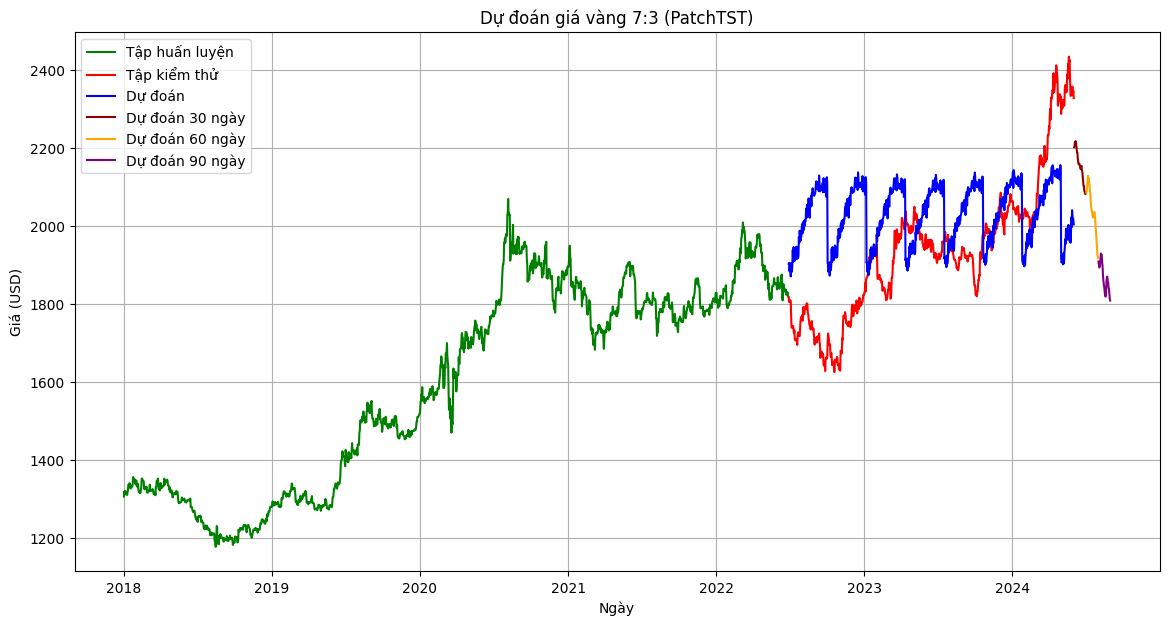

In [3]:
# Chạy với tỷ lệ 7-3
train_and_evaluate_gold(0.7)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Mse,Rmse,Mae,Mape
1,0.186600,1.159772,71000.023438,266.458282,244.044907,10.532523
2,0.069300,0.746741,45714.687500,213.809937,196.254517,8.472985
3,0.053000,0.687095,42063.222656,205.093201,188.266418,8.136484
4,0.037100,0.656591,40195.777344,200.488846,184.145340,7.961840
5,0.025900,0.407891,24970.666016,158.021088,141.880997,6.132798
6,0.023300,0.527354,32284.080078,179.677719,161.348709,6.955531
7,0.022800,0.536731,32858.109375,181.268066,166.079147,7.178816
8,0.020900,0.656769,40206.675781,200.516022,185.042007,8.000054
9,0.019600,0.638126,39065.402344,197.649689,181.345520,7.837077
10,0.020800,0.657793,40269.378906,200.672318,181.487183,7.825827


Test results: {'eval_loss': 0.4078911542892456, 'eval_mse': 24970.666015625, 'eval_rmse': 158.02108764648438, 'eval_mae': 141.88099670410156, 'eval_mape': 6.132797524333, 'eval_runtime': 0.0181, 'eval_samples_per_second': 55.255, 'eval_steps_per_second': 55.255, 'epoch': 15.0}
Actual Values:
[2372.09430308 2333.97120766 2334.49536731 2334.47574795 2338.79012048
 2353.80516142 2357.45973341 2335.80679701 2346.81571137 2327.90334359]
Predicted Values:
[2229.707  2241.6016 2232.8926 2229.2014 2208.2136 2215.9045 2259.3066
 2220.612  2273.0967 2256.8958]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


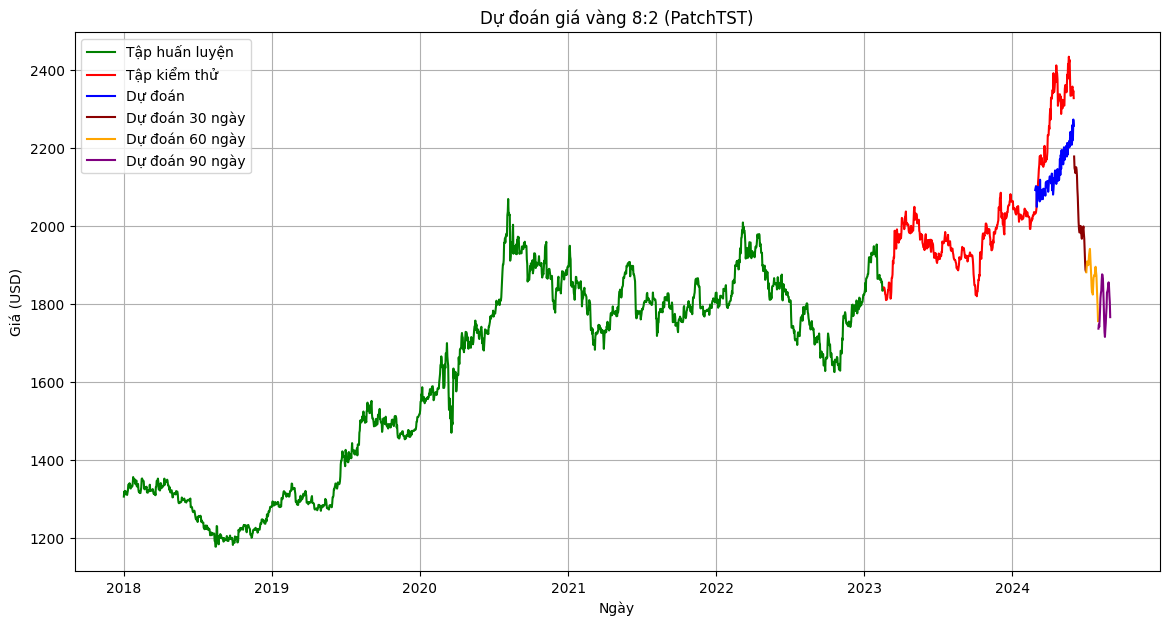

In [4]:
# Chạy với tỷ lệ 8-2
train_and_evaluate_gold(0.8)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Mse,Rmse,Mae,Mape
1,0.122100,1.004425,65368.468750,255.672577,235.676163,10.179933
2,0.077100,1.128638,73452.335938,271.020905,241.864304,10.406487
3,0.061100,1.067810,69493.617188,263.616425,243.127121,10.502338
4,0.048000,0.287980,18741.871094,136.900955,120.842407,5.207438
5,0.039800,0.873314,56835.750000,238.402496,221.126648,9.564343
6,0.032300,0.082369,5360.646973,73.216438,58.308971,2.522857
7,0.026100,0.620372,40374.105469,200.933090,184.246048,7.962000
8,0.022400,0.216091,14063.297852,118.588776,106.560638,4.659295
9,0.018600,0.270227,17586.513672,132.614151,115.814331,5.015081
10,0.017600,0.368322,23970.585938,154.824371,138.242798,6.019193


Test results: {'eval_loss': 0.08236948400735855, 'eval_mse': 5360.64697265625, 'eval_rmse': 73.21643829345703, 'eval_mae': 58.3089714050293, 'eval_mape': 2.522856555879116, 'eval_runtime': 0.0173, 'eval_samples_per_second': 57.749, 'eval_steps_per_second': 57.749, 'epoch': 16.0}
Actual Values:
[2372.09430308 2333.97120766 2334.49536731 2334.47574795 2338.79012048
 2353.80516142 2357.45973341 2335.80679701 2346.81571137 2327.90334359]
Predicted Values:
[2254.9568 2281.244  2243.533  2262.934  2252.816  2270.3254 2314.23
 2300.306  2345.5999 2294.8342]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


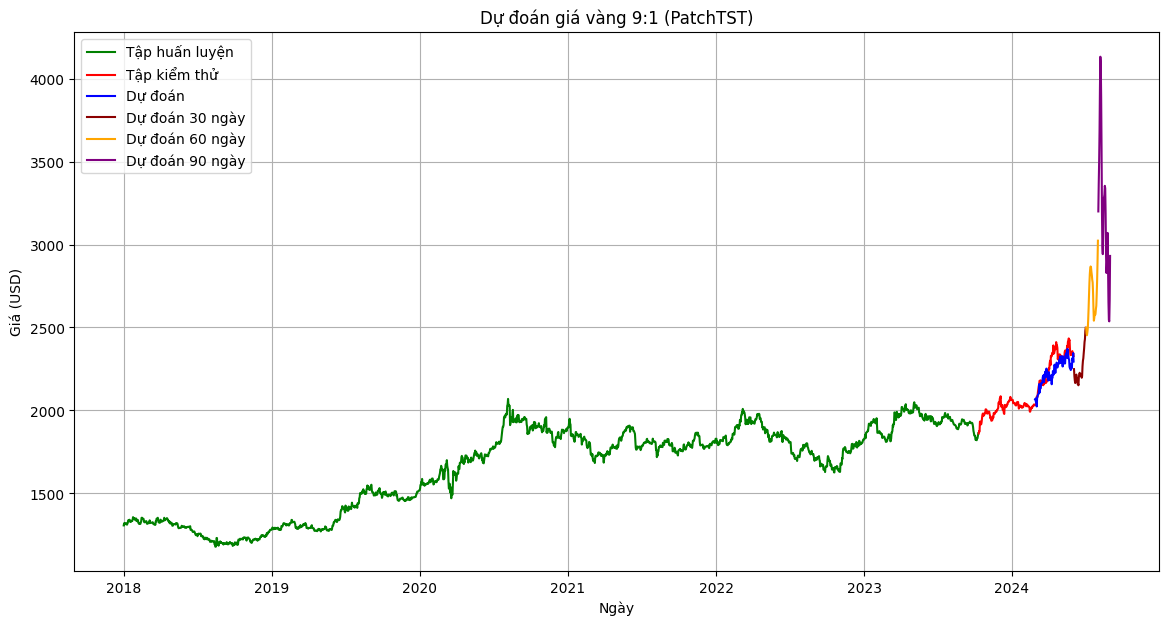

In [5]:
# Chạy với tỷ lệ 9-1
train_and_evaluate_gold(0.9)

SILVER PRICE

In [6]:

# Đọc dữ liệu từ file CSV
data = pd.read_csv('/content/silver_price_2018_2024.csv')

# Chuyển đổi cột Date thành định dạng datetime
data['Date'] = pd.to_datetime(data['Date'])
timestamp_column = 'Date'
forecast_columns = ['Value (USD per troy ounce)']

def train_and_evaluate_silver(train_ratio):
    # Chia dữ liệu thành tập huấn luyện và kiểm tra theo tỷ lệ train_ratio
    train_size = int(len(data) * train_ratio)
    test_size = len(data) - train_size
    train, test = train_test_split(data, test_size=test_size, shuffle=False)

    # Chuẩn bị scaler riêng để sử dụng
    scaler = StandardScaler()

    # Fit scaler trên dữ liệu huấn luyện
    train_scaled = scaler.fit_transform(train[forecast_columns])
    test_scaled = scaler.transform(test[forecast_columns])

    # Tạo DataFrame mới với dữ liệu đã chuẩn hóa và giữ lại cột 'Date'
    train_scaled_df = pd.DataFrame(train_scaled, columns=forecast_columns, index=train.index)
    test_scaled_df = pd.DataFrame(test_scaled, columns=forecast_columns, index=test.index)
    train_scaled_df['Date'] = train['Date']
    test_scaled_df['Date'] = test['Date']

    # Đảm bảo context_length không vượt quá độ dài chuỗi đầu vào và tối thiểu là 128
    min_context_length = 128  # Thiết lập context_length tối thiểu
    max_context_length = min(512, len(train_scaled_df), len(test_scaled_df))
    context_length = max(max_context_length, min_context_length)  # Đảm bảo context_length không nhỏ hơn min_context_length

    # Chuyển đổi dữ liệu thành định dạng thích hợp cho mô hình PatchTST
    forecast_horizon = 96
    patch_length = 16
    num_workers = 0  # Đặt số lượng luồng xử lý thành 0 để tránh multiprocessing
    batch_size = 64

    # Chuẩn bị dữ liệu sử dụng scaler đã chuẩn hóa
    time_series_preprocessor = TimeSeriesPreprocessor(
        timestamp_column=timestamp_column,
        id_columns=[],
        input_columns=forecast_columns,
        output_columns=forecast_columns,
        scaling=False,  # Đã chuẩn hóa bên ngoài
    )

    train_data = select_by_index(train_scaled_df, start_index=0, end_index=len(train_scaled_df))
    test_data = select_by_index(test_scaled_df, start_index=0, end_index=len(test_scaled_df))

    time_series_preprocessor = time_series_preprocessor.train(train_data)

    train_dataset = ForecastDFDataset(
        time_series_preprocessor.preprocess(train_data),
        id_columns=[],
        timestamp_column=timestamp_column,
        target_columns=forecast_columns,
        context_length=context_length,
        prediction_length=forecast_horizon,
    )

    test_dataset = ForecastDFDataset(
        time_series_preprocessor.preprocess(test_data),
        id_columns=[],
        timestamp_column=timestamp_column,
        target_columns=forecast_columns,
        context_length=context_length,
        prediction_length=forecast_horizon,
    )

    # Cấu hình mô hình PatchTST
    config = PatchTSTConfig(
        num_input_channels=len(forecast_columns),
        context_length=context_length,
        patch_length=patch_length,
        patch_stride=patch_length,
        prediction_length=forecast_horizon,
        random_mask_ratio=0.4,
        d_model=128,
        num_attention_heads=16,
        num_hidden_layers=3,
        ffn_dim=256,
        dropout=0.2,
        head_dropout=0.2,
        pooling_type=None,
        channel_attention=False,
        scaling="std",
        loss="mse",
        pre_norm=True,
        norm_type="batchnorm",
    )
    model = PatchTSTForPrediction(config)

    # Định nghĩa hàm tính toán các metric
    def compute_metrics(eval_pred):
        predictions, labels = eval_pred
        if isinstance(predictions, tuple):
            predictions = predictions[0]

        if len(predictions.shape) > 2:
            predictions = predictions.reshape(-1, predictions.shape[-1])
        if len(labels.shape) > 2:
            labels = labels.reshape(-1, labels.shape[-1])

        # Unscale predictions and labels
        predictions_unscaled = scaler.inverse_transform(predictions)
        labels_unscaled = scaler.inverse_transform(labels)

        mse = mean_squared_error(labels_unscaled, predictions_unscaled)
        rmse = np.sqrt(mse)
        mae = np.mean(np.abs(labels_unscaled - predictions_unscaled))
        mape = np.mean(np.abs((labels_unscaled - predictions_unscaled) / labels_unscaled)) * 100

        return {
            'mse': mse,
            'rmse': rmse,
            'mae': mae,
            'mape': mape
        }


    # Thiết lập các tham số huấn luyện
    training_args = TrainingArguments(
        output_dir="./checkpoint/patchtst/silver_price/output/",
        overwrite_output_dir=True,
        num_train_epochs=100,
        do_eval=True,
        evaluation_strategy="epoch",
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        dataloader_num_workers=num_workers,
        save_strategy="epoch",
        logging_strategy="epoch",
        save_total_limit=3,
        logging_dir="./checkpoint/patchtst/silver_price/pretrain/logs/",  # Make sure to specify a logging directory
        load_best_model_at_end=True,  # Load the best model when training ends
        metric_for_best_model="eval_loss",  # Metric to monitor for early stopping
        greater_is_better=False,  # For loss
        label_names=["future_values"],
        optim="adamw_torch",  # Specifies the optimizer
        learning_rate=1e-3,  # Specifies learning rate for Adam optimizer
    )

    early_stopping_callback = EarlyStoppingCallback(
        early_stopping_patience=10,
        early_stopping_threshold=0.0001,
    )

    # Huấn luyện mô hình
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        compute_metrics=compute_metrics,
        callbacks=[early_stopping_callback],
    )

    # Huấn luyện và đánh giá mô hình
    trainer.train()
    results = trainer.evaluate(test_dataset)
    print("Test results:", results)

    # Dự đoán bằng cách sử dụng trainer
    predicted_output = trainer.predict(test_dataset)
    predicted_values = predicted_output.predictions

    # Access the first array in the tuple (predictions)
    predictions = predicted_values[0]

    # Reshape predictions if necessary
    if len(predictions.shape) > 2:
        predictions = predictions.reshape(-1, predictions.shape[-1])

    # Unscaling predictions to original values using scaler
    predictions_unscaled = scaler.inverse_transform(predictions)

    # Calculate mean prediction across the forecast horizon if applicable
    predictions_mean = predictions_unscaled.mean(axis=1)

    # Align the predictions with the test dates
    test_dates = test['Date'].iloc[-len(predictions_mean):]

    # Make sure predictions are aligned with test_dates
    if len(predictions_mean) > len(test_dates):
        predictions_mean = predictions_mean[:len(test_dates)]

    # Print some actual and predicted values for comparison
    print("Actual Values:")
    print(test['Value (USD per troy ounce)'].values[-10:])
    print("Predicted Values:")
    print(predictions_mean[-10:])

    # [RETAINED] Forecast for the next 90 days
    forecast_horizon = 90

    # Đảm bảo context_length không vượt quá độ dài chuỗi đầu vào
    context_length = min(512, len(test[forecast_columns].values))

    last_known_data = test[forecast_columns].values[-context_length:]
    last_known_data = last_known_data.reshape(1, context_length, len(forecast_columns))
    last_known_data_scaled = scaler.transform(last_known_data.reshape(-1, len(forecast_columns))).reshape(1, context_length, len(forecast_columns))
    last_date = data['Date'].max()
    future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=forecast_horizon)

    future_predictions = []
    for i in range(forecast_horizon):
        with torch.no_grad():
            prediction = model(torch.tensor(last_known_data_scaled, dtype=torch.float32))
        prediction_outputs = prediction.prediction_outputs
        next_value_scaled = prediction_outputs[:, -1, :].numpy()
        next_value = scaler.inverse_transform(next_value_scaled)
        future_predictions.append(next_value[0, 0])
        next_value_scaled = next_value_scaled.reshape(1, 1, len(forecast_columns))
        last_known_data_scaled = np.append(last_known_data_scaled[:, 1:, :], next_value_scaled, axis=1)

    future_predictions_df = pd.DataFrame({
        'Date': future_dates,
        'Predicted Value (USD per troy ounce)': future_predictions
    })

    # Tính toán tỷ lệ train-test
    train_ratio_display = round(train_ratio * 10)
    test_ratio_display = round((1 - train_ratio) * 10)

    # Đảm bảo tỷ lệ luôn có tổng là 10
    if train_ratio_display + test_ratio_display != 10:
        train_ratio_display = 10 - test_ratio_display

    # Vẽ biểu đồ
    plt.figure(figsize=(14, 7))

    # Plot training data
    plt.plot(train['Date'], train['Value (USD per troy ounce)'], label='Tập huấn luyện', color='green')

    # Plot testing data
    plt.plot(test['Date'], test['Value (USD per troy ounce)'], label='Tập kiểm thử', color='red')

    # Plot predicted values
    plt.plot(test_dates, predictions_mean, label='Dự đoán', color='blue')

    # Highlight specific forecast periods
    plt.plot(future_predictions_df['Date'][:30], future_predictions_df['Predicted Value (USD per troy ounce)'][:30], color='darkred', label='Dự đoán 30 ngày')
    plt.plot(future_predictions_df['Date'][30:60], future_predictions_df['Predicted Value (USD per troy ounce)'][30:60], color='orange', label='Dự đoán 60 ngày')
    plt.plot(future_predictions_df['Date'][60:], future_predictions_df['Predicted Value (USD per troy ounce)'][60:], color='purple', label='Dự đoán 90 ngày')

    plt.xlabel('Ngày')
    plt.ylabel('Giá (USD)')
    plt.title('Dự đoán giá bạc {}:{} (PatchTST)'.format(train_ratio_display, test_ratio_display))
    plt.legend()
    plt.grid(True)
    plt.show()





/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Mse,Rmse,Mae,Mape
1,0.409400,0.224256,4.536895,2.129999,1.587935,6.211434
2,0.207400,0.270602,5.474506,2.339766,1.724963,6.703633
3,0.097100,0.390998,7.910225,2.812512,1.890944,7.184749
4,0.077600,0.380231,7.692385,2.773515,1.911599,7.301210
5,0.057000,0.386711,7.823494,2.797051,1.934010,7.384904
6,0.046800,0.337008,6.817948,2.611120,1.831787,7.020718
7,0.039900,0.388397,7.857605,2.803142,1.935242,7.386359
8,0.035300,0.331577,6.708091,2.589998,1.814342,6.959645
9,0.031800,0.374201,7.570410,2.751438,1.962450,7.528703
10,0.036300,0.334655,6.770363,2.601992,1.779721,6.794582


Test results: {'eval_loss': 0.22425629198551178, 'eval_mse': 4.536894798278809, 'eval_rmse': 2.1299986839294434, 'eval_mae': 1.5879346132278442, 'eval_mape': 6.211433559656143, 'eval_runtime': 0.112, 'eval_samples_per_second': 866.422, 'eval_steps_per_second': 17.864, 'epoch': 11.0}
Actual Values:
[30.453572   30.37448803 30.35655692 30.35630691 30.60042939 31.79054376
 31.99213004 31.82585989 31.13789443 30.40818864]
Predicted Values:
[23.799507 23.389107 24.016783 23.77018  23.608334 24.24282  22.998304
 23.953241 23.527992 23.787638]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


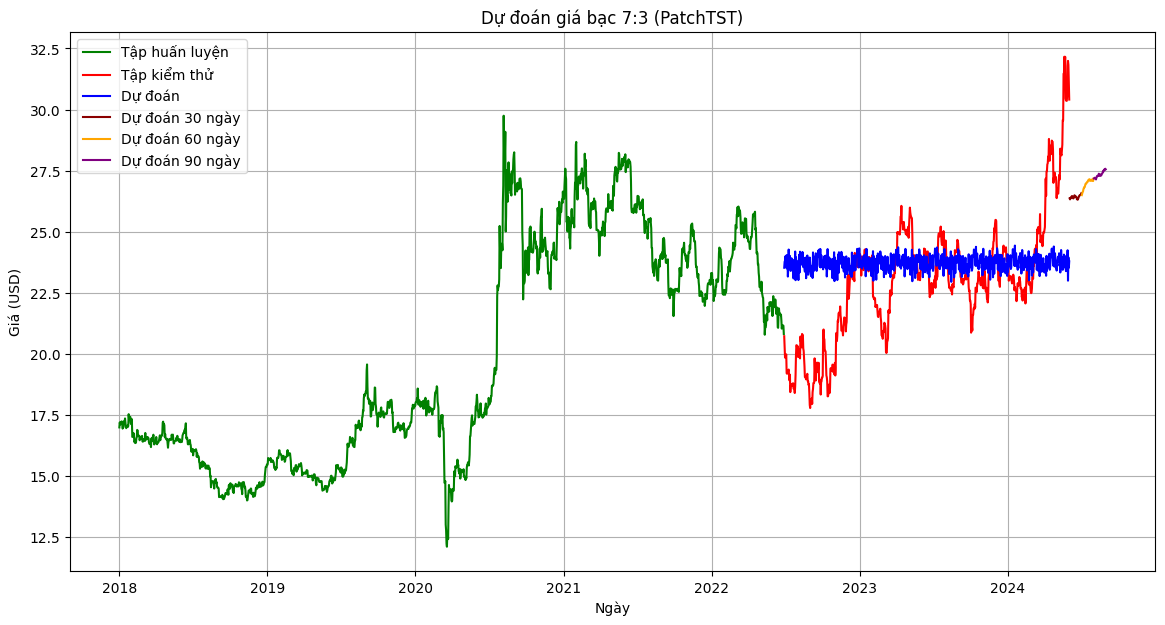

In [7]:
# Chạy với tỷ lệ 7-3
train_and_evaluate_silver(0.7)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Mse,Rmse,Mae,Mape
1,0.402700,0.932602,17.063154,4.130757,3.410173,11.972084
2,0.214300,1.240791,22.701880,4.764649,4.014411,14.136474
3,0.127300,1.245255,22.783545,4.773211,4.079201,14.405863
4,0.093000,1.281671,23.449827,4.842502,4.194247,14.850633
5,0.071400,1.272458,23.281260,4.825066,4.205612,14.911187
6,0.060700,1.098898,20.105751,4.483943,3.872724,13.706873
7,0.051100,1.142907,20.910961,4.572850,3.927375,13.883375
8,0.045300,0.984301,18.009060,4.243708,3.576118,12.596484
9,0.039200,0.887393,16.236008,4.029393,3.414862,12.045515
10,0.035300,0.915825,16.756205,4.093434,3.477105,12.269425


Test results: {'eval_loss': 0.8873934149742126, 'eval_mse': 16.236007690429688, 'eval_rmse': 4.029393196105957, 'eval_mae': 3.4148623943328857, 'eval_mape': 12.045515328645706, 'eval_runtime': 0.0117, 'eval_samples_per_second': 85.429, 'eval_steps_per_second': 85.429, 'epoch': 19.0}
Actual Values:
[30.453572   30.37448803 30.35655692 30.35630691 30.60042939 31.79054376
 31.99213004 31.82585989 31.13789443 30.40818864]
Predicted Values:
[23.898647 23.961596 24.029707 24.285587 24.280128 24.305582 24.568415
 24.639668 24.664373 24.77964 ]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


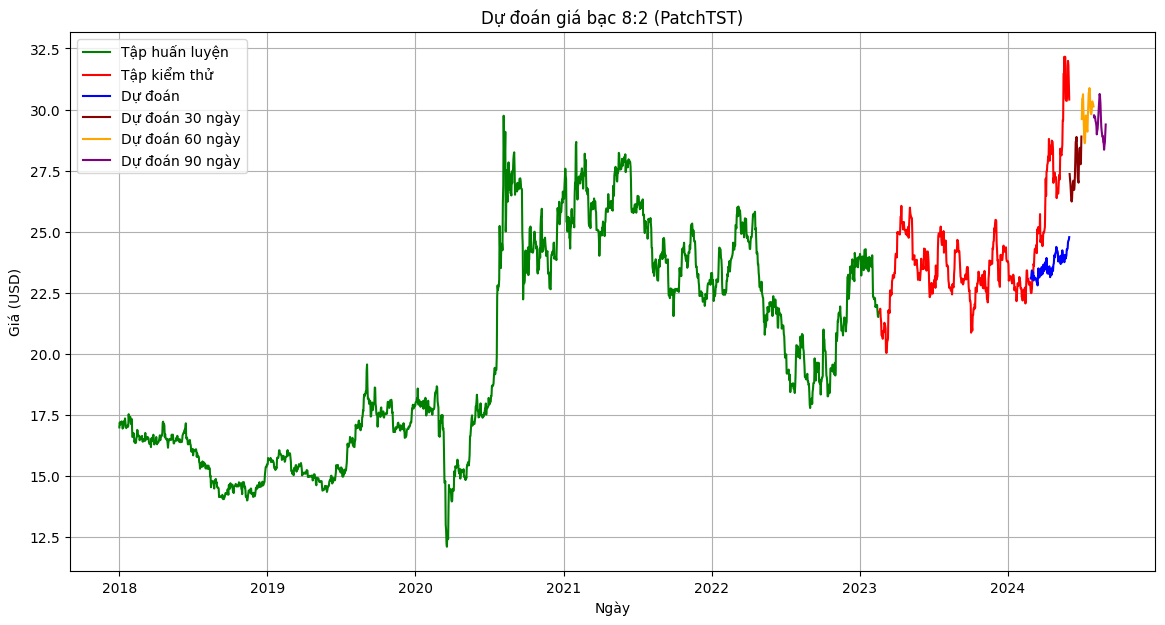

In [8]:
# Chạy với tỷ lệ 8-2
train_and_evaluate_silver(0.8)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Mse,Rmse,Mae,Mape
1,0.256600,1.321187,23.312845,4.828338,4.120373,14.541416
2,0.136900,1.363180,24.053831,4.904470,4.074042,14.304481
3,0.110400,1.359863,23.995300,4.898500,4.077921,14.326197
4,0.096500,1.061933,18.738214,4.328766,3.398282,11.821119
5,0.080500,1.064147,18.777273,4.333275,3.408459,11.853715
6,0.075100,0.945526,16.684160,4.084625,3.214589,11.183549
7,0.059200,1.042933,18.402954,4.289866,3.480735,12.167603
8,0.053500,0.905164,15.971972,3.996495,3.157347,10.984235
9,0.052100,1.234761,21.787825,4.667743,3.744305,13.066410
10,0.056300,0.943079,16.640993,4.079337,3.325104,11.631612


Test results: {'eval_loss': 0.8944425582885742, 'eval_mse': 15.7827787399292, 'eval_rmse': 3.97275447845459, 'eval_mae': 3.2292659282684326, 'eval_mape': 11.293935775756836, 'eval_runtime': 0.0118, 'eval_samples_per_second': 84.797, 'eval_steps_per_second': 84.797, 'epoch': 23.0}
Actual Values:
[30.453572   30.37448803 30.35655692 30.35630691 30.60042939 31.79054376
 31.99213004 31.82585989 31.13789443 30.40818864]
Predicted Values:
[24.182856 24.182558 24.146658 24.235865 24.235947 24.118378 24.163782
 24.308475 24.122608 23.96056 ]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


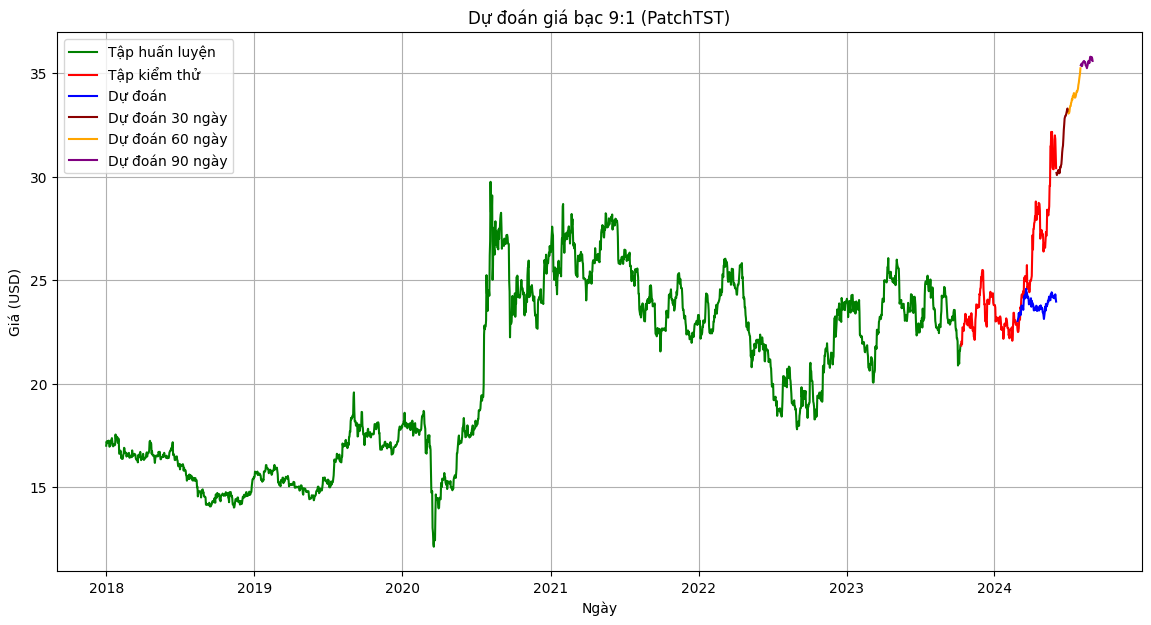

In [9]:
# Chạy với tỷ lệ 9-1
train_and_evaluate_silver(0.9)

PLATINUM PRICE

In [18]:

# Đọc dữ liệu từ file CSV
data = pd.read_csv('/content/platium_price_2018_2024.csv')

# Chuyển đổi cột Date thành định dạng datetime
data['Date'] = pd.to_datetime(data['Date'])
timestamp_column = 'Date'
forecast_columns = ['Value (USD per troy ounce)']

def train_and_evaluate_platinum(train_ratio):
    # Chia dữ liệu thành tập huấn luyện và kiểm tra theo tỷ lệ train_ratio
    train_size = int(len(data) * train_ratio)
    test_size = len(data) - train_size
    train, test = train_test_split(data, test_size=test_size, shuffle=False)

    # Chuẩn bị scaler riêng để sử dụng
    scaler = StandardScaler()

    # Fit scaler trên dữ liệu huấn luyện
    train_scaled = scaler.fit_transform(train[forecast_columns])
    test_scaled = scaler.transform(test[forecast_columns])

    # Tạo DataFrame mới với dữ liệu đã chuẩn hóa và giữ lại cột 'Date'
    train_scaled_df = pd.DataFrame(train_scaled, columns=forecast_columns, index=train.index)
    test_scaled_df = pd.DataFrame(test_scaled, columns=forecast_columns, index=test.index)
    train_scaled_df['Date'] = train['Date']
    test_scaled_df['Date'] = test['Date']

    # Đảm bảo context_length không vượt quá độ dài chuỗi đầu vào và tối thiểu là 128
    min_context_length = 128  # Thiết lập context_length tối thiểu
    max_context_length = min(512, len(train_scaled_df), len(test_scaled_df))
    context_length = max(max_context_length, min_context_length)  # Đảm bảo context_length không nhỏ hơn min_context_length

    # Chuyển đổi dữ liệu thành định dạng thích hợp cho mô hình PatchTST
    forecast_horizon = 96
    patch_length = 16
    num_workers = 0  # Đặt số lượng luồng xử lý thành 0 để tránh multiprocessing
    batch_size = 64

    # Chuẩn bị dữ liệu sử dụng scaler đã chuẩn hóa
    time_series_preprocessor = TimeSeriesPreprocessor(
        timestamp_column=timestamp_column,
        id_columns=[],
        input_columns=forecast_columns,
        output_columns=forecast_columns,
        scaling=False,  # Đã chuẩn hóa bên ngoài
    )

    train_data = select_by_index(train_scaled_df, start_index=0, end_index=len(train_scaled_df))
    test_data = select_by_index(test_scaled_df, start_index=0, end_index=len(test_scaled_df))

    time_series_preprocessor = time_series_preprocessor.train(train_data)

    train_dataset = ForecastDFDataset(
        time_series_preprocessor.preprocess(train_data),
        id_columns=[],
        timestamp_column=timestamp_column,
        target_columns=forecast_columns,
        context_length=context_length,
        prediction_length=forecast_horizon,
    )

    test_dataset = ForecastDFDataset(
        time_series_preprocessor.preprocess(test_data),
        id_columns=[],
        timestamp_column=timestamp_column,
        target_columns=forecast_columns,
        context_length=context_length,
        prediction_length=forecast_horizon,
    )

    # Cấu hình mô hình PatchTST
    config = PatchTSTConfig(
        num_input_channels=len(forecast_columns),
        context_length=context_length,
        patch_length=patch_length,
        patch_stride=patch_length,
        prediction_length=forecast_horizon,
        random_mask_ratio=0.4,
        d_model=128,
        num_attention_heads=16,
        num_hidden_layers=3,
        ffn_dim=256,
        dropout=0.2,
        head_dropout=0.2,
        pooling_type=None,
        channel_attention=False,
        scaling="std",
        loss="mse",
        pre_norm=True,
        norm_type="batchnorm",
    )
    model = PatchTSTForPrediction(config)

    # Định nghĩa hàm tính toán các metric
    def compute_metrics(eval_pred):
        predictions, labels = eval_pred
        if isinstance(predictions, tuple):
            predictions = predictions[0]

        if len(predictions.shape) > 2:
            predictions = predictions.reshape(-1, predictions.shape[-1])
        if len(labels.shape) > 2:
            labels = labels.reshape(-1, labels.shape[-1])

        # Unscale predictions and labels
        predictions_unscaled = scaler.inverse_transform(predictions)
        labels_unscaled = scaler.inverse_transform(labels)

        mse = mean_squared_error(labels_unscaled, predictions_unscaled)
        rmse = np.sqrt(mse)
        mae = np.mean(np.abs(labels_unscaled - predictions_unscaled))
        mape = np.mean(np.abs((labels_unscaled - predictions_unscaled) / labels_unscaled)) * 100

        return {
            'mse': mse,
            'rmse': rmse,
            'mae': mae,
            'mape': mape
        }


    # Thiết lập các tham số huấn luyện
    training_args = TrainingArguments(
        output_dir="./checkpoint/patchtst/platinum_price/output/",
        overwrite_output_dir=True,
        num_train_epochs=100,
        do_eval=True,
        evaluation_strategy="epoch",
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        dataloader_num_workers=num_workers,
        save_strategy="epoch",
        logging_strategy="epoch",
        save_total_limit=3,
        logging_dir="./checkpoint/patchtst/platinum_price/pretrain/logs/",  # Make sure to specify a logging directory
        load_best_model_at_end=True,  # Load the best model when training ends
        metric_for_best_model="eval_loss",  # Metric to monitor for early stopping
        greater_is_better=False,  # For loss
        label_names=["future_values"],
        optim="adamw_torch",  # Specifies the optimizer
        learning_rate=1e-3,  # Specifies learning rate for Adam optimizer
    )

    early_stopping_callback = EarlyStoppingCallback(
        early_stopping_patience=10,
        early_stopping_threshold=0.0001,
    )

    # Huấn luyện mô hình
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        compute_metrics=compute_metrics,
        callbacks=[early_stopping_callback],
    )

    # Huấn luyện và đánh giá mô hình
    trainer.train()
    results = trainer.evaluate(test_dataset)
    print("Test results:", results)

    # Dự đoán bằng cách sử dụng trainer
    predicted_output = trainer.predict(test_dataset)
    predicted_values = predicted_output.predictions

    # Access the first array in the tuple (predictions)
    predictions = predicted_values[0]

    # Reshape predictions if necessary
    if len(predictions.shape) > 2:
        predictions = predictions.reshape(-1, predictions.shape[-1])

    # Unscaling predictions to original values using scaler
    predictions_unscaled = scaler.inverse_transform(predictions)

    # Calculate mean prediction across the forecast horizon if applicable
    predictions_mean = predictions_unscaled.mean(axis=1)

    # Align the predictions with the test dates
    test_dates = test['Date'].iloc[-len(predictions_mean):]

    # Make sure predictions are aligned with test_dates
    if len(predictions_mean) > len(test_dates):
        predictions_mean = predictions_mean[:len(test_dates)]

    # Print some actual and predicted values for comparison
    print("Actual Values:")
    print(test['Value (USD per troy ounce)'].values[-10:])
    print("Predicted Values:")
    print(predictions_mean[-10:])

    # [RETAINED] Forecast for the next 90 days
    forecast_horizon = 90

    # Đảm bảo context_length không vượt quá độ dài chuỗi đầu vào
    context_length = min(512, len(test[forecast_columns].values))

    last_known_data = test[forecast_columns].values[-context_length:]
    last_known_data = last_known_data.reshape(1, context_length, len(forecast_columns))
    last_known_data_scaled = scaler.transform(last_known_data.reshape(-1, len(forecast_columns))).reshape(1, context_length, len(forecast_columns))
    last_date = data['Date'].max()
    future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=forecast_horizon)

    future_predictions = []
    for i in range(forecast_horizon):
        with torch.no_grad():
            prediction = model(torch.tensor(last_known_data_scaled, dtype=torch.float32))
        prediction_outputs = prediction.prediction_outputs
        next_value_scaled = prediction_outputs[:, -1, :].numpy()
        next_value = scaler.inverse_transform(next_value_scaled)
        future_predictions.append(next_value[0, 0])
        next_value_scaled = next_value_scaled.reshape(1, 1, len(forecast_columns))
        last_known_data_scaled = np.append(last_known_data_scaled[:, 1:, :], next_value_scaled, axis=1)

    future_predictions_df = pd.DataFrame({
        'Date': future_dates,
        'Predicted Value (USD per troy ounce)': future_predictions
    })

    # Tính toán tỷ lệ train-test
    train_ratio_display = round(train_ratio * 10)
    test_ratio_display = round((1 - train_ratio) * 10)

    # Đảm bảo tỷ lệ luôn có tổng là 10
    if train_ratio_display + test_ratio_display != 10:
        train_ratio_display = 10 - test_ratio_display

    # Vẽ biểu đồ
    plt.figure(figsize=(14, 7))

    # Plot training data
    plt.plot(train['Date'], train['Value (USD per troy ounce)'], label='Tập huấn luyện', color='green')

    # Plot testing data
    plt.plot(test['Date'], test['Value (USD per troy ounce)'], label='Tập kiểm thử', color='red')

    # Plot predicted values
    plt.plot(test_dates, predictions_mean, label='Dự đoán', color='blue')

    # Highlight specific forecast periods
    plt.plot(future_predictions_df['Date'][:30], future_predictions_df['Predicted Value (USD per troy ounce)'][:30], color='darkred', label='Dự đoán 30 ngày')
    plt.plot(future_predictions_df['Date'][30:60], future_predictions_df['Predicted Value (USD per troy ounce)'][30:60], color='orange', label='Dự đoán 60 ngày')
    plt.plot(future_predictions_df['Date'][60:], future_predictions_df['Predicted Value (USD per troy ounce)'][60:], color='purple', label='Dự đoán 90 ngày')

    plt.xlabel('Ngày')
    plt.ylabel('Giá (USD)')
    plt.title('Dự đoán giá bạch kim {}:{} (PatchTST)'.format(train_ratio_display, test_ratio_display))
    plt.legend()
    plt.grid(True)
    plt.show()





/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Mse,Rmse,Mae,Mape
1,0.544200,0.324198,4578.551758,67.664993,62.284611,6.821269
2,0.235000,0.240706,3399.424805,58.304588,53.212471,5.821902
3,0.163900,0.175584,2479.715088,49.796738,44.803864,4.889706
4,0.122400,0.126402,1785.142578,42.250946,32.992146,3.524842
5,0.087500,0.115483,1630.931885,40.384796,33.712093,3.640396
6,0.069300,0.114894,1622.608032,40.281609,33.503357,3.621215
7,0.066900,0.112902,1594.481445,39.930958,32.912003,3.560150
8,0.058500,0.109604,1547.899292,39.343349,32.035625,3.471112
9,0.058800,0.142655,2014.676514,44.885147,38.200558,4.151095
10,0.054200,0.117454,1658.772583,40.728031,33.539085,3.617740


Test results: {'eval_loss': 0.10960360616445541, 'eval_mse': 1547.8992919921875, 'eval_rmse': 39.34334945678711, 'eval_mae': 32.03562545776367, 'eval_mape': 3.4711115062236786, 'eval_runtime': 0.1618, 'eval_samples_per_second': 599.337, 'eval_steps_per_second': 12.357, 'epoch': 18.0}
Actual Values:
[1035.31543784 1026.49053868  994.53384309  994.6406771  1042.0323549
 1062.33314066 1063.88796153 1036.77782722 1027.96612687 1009.07134962]
Predicted Values:
[942.154   943.66693 943.5291  945.0919  937.71545 943.787   930.8933
 933.1649  937.2401  947.04333]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


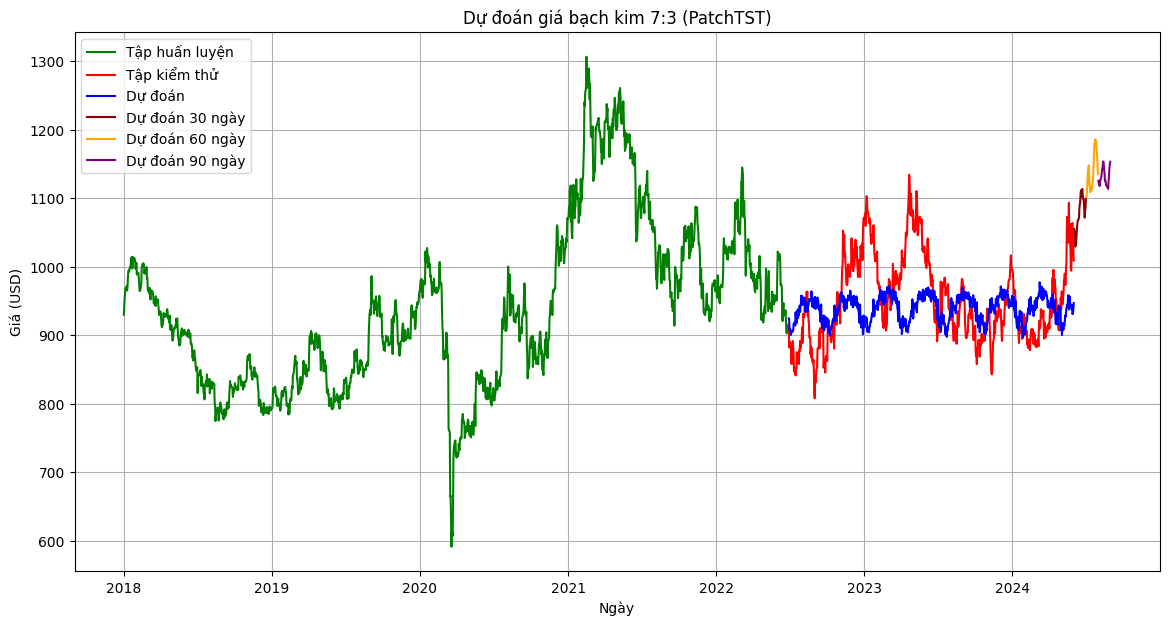

In [15]:
# Chạy với tỷ lệ 7-3
train_and_evaluate_platinum(0.7)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Mse,Rmse,Mae,Mape
1,0.591200,0.209864,2727.464600,52.225132,40.733593,4.154967
2,0.244300,0.257002,3340.085205,57.793468,46.079670,4.717103
3,0.169100,0.324640,4219.124512,64.954788,53.247204,5.472898
4,0.138000,0.381156,4953.629395,70.382027,54.236359,5.519126
5,0.116300,0.364659,4739.220215,68.841995,53.338318,5.428633
6,0.091600,0.327676,4258.582031,65.257812,50.640583,5.165913
7,0.084200,0.332819,4325.419922,65.767921,55.265110,5.718006
8,0.068900,0.329893,4287.400391,65.478241,56.032745,5.812439
9,0.061600,0.269841,3506.936768,59.219395,48.723541,5.020960
10,0.063800,0.336211,4369.507324,66.102249,54.696705,5.633533


Test results: {'eval_loss': 0.20986442267894745, 'eval_mse': 2727.464599609375, 'eval_rmse': 52.22513198852539, 'eval_mae': 40.73359298706055, 'eval_mape': 4.1549671441316605, 'eval_runtime': 0.0122, 'eval_samples_per_second': 82.092, 'eval_steps_per_second': 82.092, 'epoch': 11.0}
Actual Values:
[1035.31543784 1026.49053868  994.53384309  994.6406771  1042.0323549
 1062.33314066 1063.88796153 1036.77782722 1027.96612687 1009.07134962]
Predicted Values:
[932.4058  952.4029  943.8014  940.3352  946.71295 960.7257  951.08264
 942.03845 952.8401  938.5701 ]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


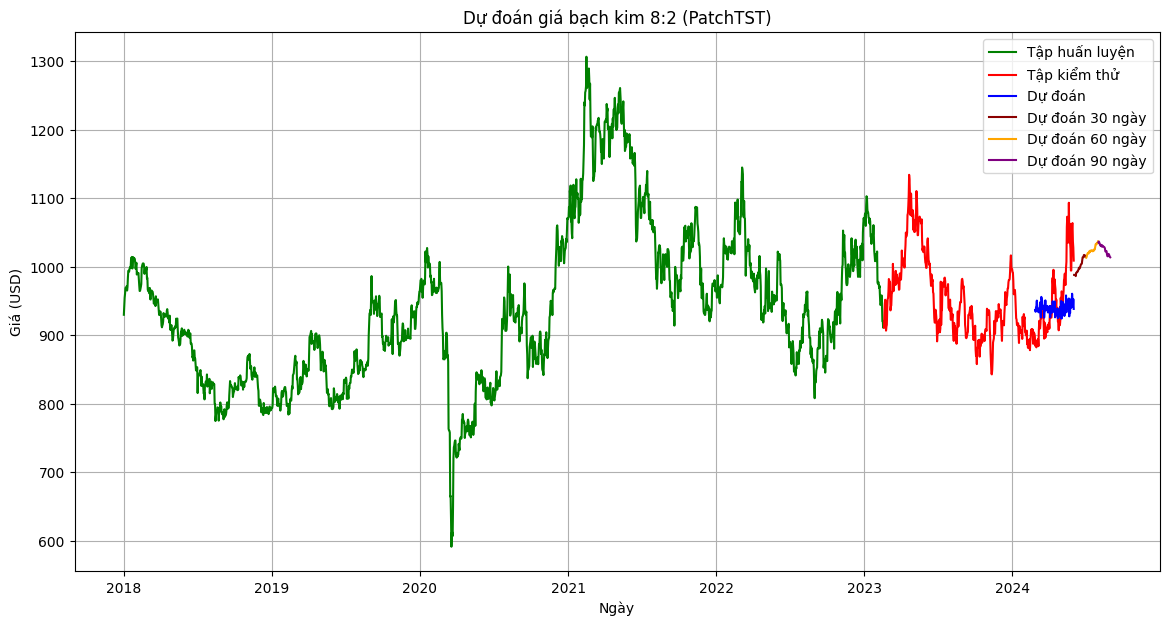

In [16]:
# Chạy với tỷ lệ 8-2
train_and_evaluate_platinum(0.8)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Mse,Rmse,Mae,Mape
1,0.674800,0.343665,4149.645996,64.417747,45.176716,4.510869
2,0.466900,0.277671,3352.789062,57.903275,40.303425,4.023195
3,0.378300,0.272410,3289.264404,57.352108,38.928436,3.880950
4,0.289100,0.279967,3380.513428,58.142181,40.300541,4.041510
5,0.251500,0.280883,3391.578857,58.237263,42.338814,4.256887
6,0.206400,0.360621,4354.382324,65.987747,46.829624,4.680558
7,0.194000,0.312636,3774.979736,61.440865,42.045418,4.194467
8,0.154100,0.264092,3188.826172,56.469692,39.148037,3.909578
9,0.140700,0.260916,3150.481689,56.129150,39.809124,3.984759
10,0.107300,0.323780,3909.540039,62.526314,45.346142,4.545010


Test results: {'eval_loss': 0.2456292062997818, 'eval_mse': 2965.896484375, 'eval_rmse': 54.460044860839844, 'eval_mae': 37.84011459350586, 'eval_mape': 3.796570375561714, 'eval_runtime': 0.011, 'eval_samples_per_second': 90.533, 'eval_steps_per_second': 90.533, 'epoch': 25.0}
Actual Values:
[1035.31543784 1026.49053868  994.53384309  994.6406771  1042.0323549
 1062.33314066 1063.88796153 1036.77782722 1027.96612687 1009.07134962]
Predicted Values:
[936.7633  925.7615  944.2983  948.3274  937.79425 949.94836 933.7739
 939.41296 941.50085 943.03705]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


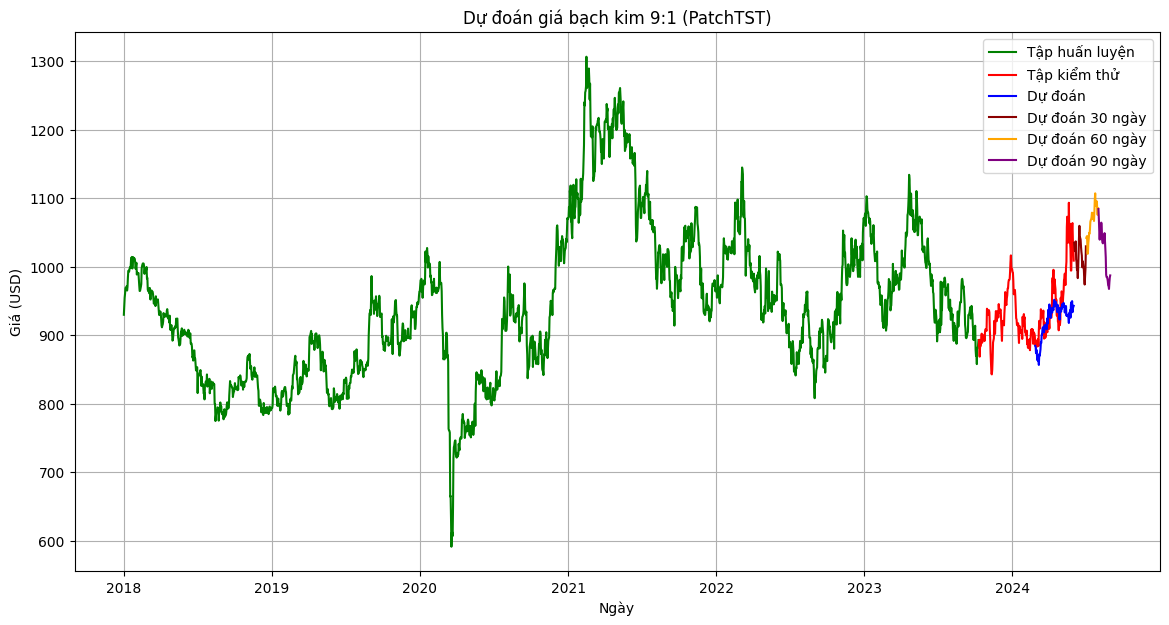

In [19]:
# Chạy với tỷ lệ 9-1
train_and_evaluate_platinum(0.9)